## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 9 октября 2019

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 23 октября (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 30 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [1]:
import numpy as np
import pandas as pd
import random
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

In [2]:
# add status bar functionality

import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [3]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
data.shape

(48895, 16)

In [5]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [6]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [7]:
# конвертируем дату (строка) в число
data['last_review'] = pd.to_datetime(data['last_review'].fillna(0)).astype(int)

numberCols = data.select_dtypes(include=[np.number]).columns.tolist()
numberCols.remove('id')
numberCols.remove('price')
data[numberCols] = data[numberCols].fillna(0)

categoricalCols = ['neighbourhood_group', 'neighbourhood', 'room_type']
data[categoricalCols] = data[categoricalCols].fillna('')

textCols = ['name']
data[textCols] = data[textCols].fillna('')

Разобъем данные на обучение и контроль.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
Сигнатуру методов при желании можно менять.

In [14]:
from typing import Union, Callable, Iterable, Optional
# from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import KNeighborsRegressor

class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str = 'uniform'):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
#         self.__nn = NearestNeighbors(n_neighbors = n_neighbors, metric = metric)
#         self.__nnTest = KNeighborsRegressor(n_neighbors = n_neighbors, metric = metric, weights = mode)
        self.__metric = metric
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        # Ваш код здесь
        self.__X = X
        self.__y = y
#         self.__nn.fit(X, y)
#         self.__nnTest.fit(X, y)
        
    def euclidean_distance(self, X, Y):
        d = len(X[0])
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                sum = 0
                for f in range(len(Y[y])):
                    sum += (X[x][f] - Y[y][f])**2
                res[x][y] = np.sqrt(sum)
        return res;

    def cosine_distance(self, X, Y):
        sumyy = (Y**2).sum(1)
        sumxx = (X**2).sum(1, keepdims=1)
        sumxy = X.dot(Y.T)
        return 1 - (sumxy / np.sqrt(sumxx)) / np.sqrt(sumyy)
    
    def overlap(self, X, Y):
        res = []
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                dist = 0
                for f in range(len(Y[y])):
                    if (X[x][f] != Y[y][f]):
                        dist = 1
                        break
                res[x][y] = dist
        return res;

    def flattened_overlap(self, X, Y):
        # находим частоту признаков
        freqs = {}
        for col in range(X.shape[1]):
            values, freq = np.unique(X[:,col], return_counts = True)
            freqs[col] = {values[q]: freq[q] for q in range(len(values))} 
        
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                dist = 0
                p = 0
                for c in range(len(Y[y])):
                    if (X[x][c] != Y[y][c]):
                        dist = 1
                        break
                    else:
                        dist = dist + (freqs[c][float(X[x][c])] * (freqs[c][float(X[x][c])] - 1)) / (len(X) * (len(X) - 1))
                
                res[x][y] = dist
        return res;
    
    def log_overlap(self, X, Y):
        
        # находим частоту признаков
        freqsX = {}
        for col in range(X.shape[1]):
            values, freq = np.unique(X[:,col], return_counts=True)
            freqsX[col] = {values[q]: freq[q] for q in range(len(values))} 

        freqsY = {}
        for col in range(Y.shape[1]):
            values, freq = np.unique(Y[:,col], return_counts=True)
            freqsY[col] = {values[q]: freq[q] for q in range(len(values))} 
        
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                dist = 0
                for c in range(len(Y[y])):
                    if (X[x][c] != Y[y][c]):
                        dist = dist + np.log(1 + freqsX[c][float(X[x][c])]) * np.log(1 + freqsY[c][float(Y[x][c])])
                
                res[x][y] = dist
        return res;

    def find_kneighbors(self, X, return_distance = True):
        
        if (self.__metric == 'euclidean'):
            dsModRes = self.euclidean_distance(X, self.__X)
        elif (self.__metric == 'cosine'):
            dsModRes = self.cosine_distance(X, self.__X)
        elif (self.__metric == 'overlap'):
            dsModRes = self.overlap(X, self.__X)
        elif (self.__metric == 'flattened_overlap'):
            dsModRes = self.flattened_overlap(X, self.__X)
        elif (self.__metric == 'log_overlap'):
            dsModRes = self.log_overlap(X, self.__X)
        else:
            raise Exception("Unknown 'metric' param value")

        res = []
        dists = []
        for i in range(len(dsModRes)):
            tmpDists = np.argsort(dsModRes[i])[:self.__n_neighbors]
            res.append(dsModRes[i][tmpDists])
            if (return_distance):
                dists.append(tmpDists)

        if (return_distance):
            return (res, dists)
        else:
            return (res)
        
    def predict(self, X: np.array, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """
        # Ваш код здесь
#         distances, indices = self.__nn.kneighbors(X)
#         distances, indices = self.__nnTest.kneighbors(X)
        distances, indices = self.find_kneighbors(X)
    
        if (self.__mode == 'uniform'):
            res = self.__y[indices].mean(axis=1)
        else: 
            res = []
            for row in range(len(indices)):
                predictedVal = 0
                weightsSum = 0
                for col in range(len(indices[row])):
                    w = 1 / (1 + distances[row][col])
                    weightsSum = weightsSum + w
                    predictedVal = predictedVal + w * self.__y[indices[row][col]]
                res.append(predictedVal / weightsSum)
            res = np.array(res)
#         return self.__nnTest.predict(X)
        return res
            

Progress: [####################] 100.0%


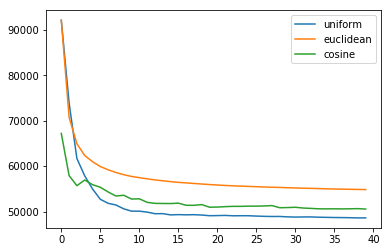

In [10]:
X_train1 = X_train[numberCols].to_numpy()
X_test1 = X_test[numberCols].to_numpy()
y_train1 = y_train.to_numpy()[:,0]
y_test1 = y_test.to_numpy()[:,0]

k_max = 40
metrics_array = ['euclidean', 'cosine']

res_matrix_length = k_max * (len(metrics_array) + 1)
process_bar_length = res_matrix_length
cur_bar_position = 0
update_progress(cur_bar_position / res_matrix_length)

res = np.zeros(k_max * len(metrics_array)).reshape(k_max, len(metrics_array))

for m in range(len(metrics_array)):
    for k in range(k_max):
        knnr = KNNRegressor(n_neighbors = k + 1, metric = metrics_array[m], mode = 'distance')
        knnr.fit(X_train1, y_train1)
        res[k][m] = mean_squared_error(y_test1, knnr.predict(X_test1))
        cur_bar_position = cur_bar_position + 1
        update_progress(cur_bar_position / res_matrix_length)

# посчитаем ошибку для uniform режима        
res_u = np.zeros(k_max)
for k in range(k_max):
    knnr = KNNRegressor(n_neighbors = k + 1, metric = 'euclidean', mode = 'uniform')
    knnr.fit(X_train1, y_train1)
    res_u[k] = mean_squared_error(y_test1, knnr.predict(X_test1))
    cur_bar_position = cur_bar_position + 1
    update_progress(cur_bar_position / res_matrix_length)

# и добавим в наш массив результатов    
res_u = res_u.reshape(k_max,1)
res1 = np.hstack((res_u, res))

# отображение результата
plt.plot(res1)
plt.legend(['uniform'] + metrics_array, loc='upper right')
plt.show() 

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на [третьем семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2019/blob/master/lecture-notes/Sem03_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [11]:
# для overlap можно не кодировать, для остальных обызательно 

labelencoder = LabelEncoder()

X_train['neighbourhood_group_encoded'] = labelencoder.fit_transform(X_train['neighbourhood_group'])
X_train['neighbourhood_encoded'] = labelencoder.fit_transform(X_train['neighbourhood'])
X_train['room_type_encoded'] = labelencoder.fit_transform(X_train['room_type'])

X_test['neighbourhood_group_encoded'] = labelencoder.fit_transform(X_test['neighbourhood_group'])
X_test['neighbourhood_encoded'] = labelencoder.fit_transform(X_test['neighbourhood'])
X_test['room_type_encoded'] = labelencoder.fit_transform(X_test['room_type'])

categoricalColsEncoded = ['neighbourhood_group_encoded', 'neighbourhood_encoded', 'room_type_encoded']

X_train2 = X_train[0:1000][categoricalColsEncoded].to_numpy()
X_test2 = X_test[0:1000][categoricalColsEncoded].to_numpy()
y_train2 = y_train[0:1000].to_numpy()[:,0]
y_test2 = y_test[0:1000].to_numpy()[:,0]

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

Progress: [####################] 100.0%


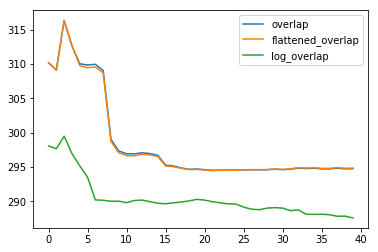

In [15]:
# Ваш код здесь
k_max = 40
metrics_array = ['overlap', 'flattened_overlap', 'log_overlap']

res_matrix_length = k_max * len(metrics_array)
process_bar_length = res_matrix_length
cur_bar_position = 0
update_progress(cur_bar_position / res_matrix_length)

res2 = np.zeros(res_matrix_length).reshape(k_max, len(metrics_array))

for m in range(len(metrics_array)):
    for k in range(0, k_max):
        knnr = KNNRegressor(n_neighbors = k + 1, metric = metrics_array[m], mode = 'distance')
        knnr.fit(X_train2, y_train2)
        pred = knnr.predict(X_test2)
        res2[k][m] = np.sqrt(mean_squared_error(y_test2, pred))
        cur_bar_position = cur_bar_position + 1
        update_progress(cur_bar_position / res_matrix_length)

plt.plot(res2)
plt.legend(metrics_array, loc='upper right')
plt.show() 

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [16]:
# Ваш код здесь
for m in range(len(metrics_array)):
    k = np.argmin(res2[:,m])
    print("Для %s оптимальное значение k = %d (результат %.4f)" % (metrics_array[m], k, res2[k,m]))

Для overlap оптимальное значение k = 21 (результат 294.4985)
Для flattened_overlap оптимальное значение k = 21 (результат 294.4680)
Для log_overlap оптимальное значение k = 39 (результат 287.5661)


<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [17]:
data['target'] = (data.price > data.price.mean()).astype(int)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [18]:
def counters(x):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    # Ваш код здесь
    pass

def counts(X: np.array) -> np.array:
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    # Ваш код здесь
    res = {}
    unique, counts = np.unique(X, return_counts = True)
    return dict(np.asarray((unique, counts)).T)

def successes(X: np.array, Y: np.array) -> np.array:
    res = {}
    
    unique = np.unique(X, return_counts = False)
    for val in unique:
        count = 0
        for row in range(len(X)):
            if ((X[row] == val) and X[row]):
                count = count + 1
        res[val] = count
    
    return res

def flattened(X: np.array, Y: np.array, a: int = 1, b: int = 2) -> np.array:
    cnts = counts(X)
    scses = successes(X, Y)
   
    res = {}
    for key in cnts:
        res[key] = (int(scses[key]) + a) / (int(cnts[key]) + b)
    
    return res

# counts(['a','b','c','a','e','d','d','f','a'])
# successes(['a','b','c','a','e','d','d','f','a'], [1,0,1,1,1,0,0,0,1])
flattened(['a','b','c','a','e','d','d','f','a'], [1,0,1,1,1,0,0,0,1])

{'a': 0.8,
 'b': 0.6666666666666666,
 'c': 0.6666666666666666,
 'd': 0.75,
 'e': 0.6666666666666666,
 'f': 0.6666666666666666}

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [19]:
def kfold(n, n_folds):
    partSize = n // n_folds
    indexes = [i for i in range(n)]
    np.random.shuffle(indexes)
    
    res = []
    for i in range(n_folds):
        test = indexes[partSize*i:partSize*(i+1)]
        valid = indexes[0:partSize*i] + indexes[partSize*(i+1):]
        res.append((test, valid))

    return res

def kcounts(X: np.array, n: int) -> np.array:
    res = {}
    
    folds = kfold(len(X), 3)
    for fold_index in range(len(folds)):
        foldValues = []
        for index in folds[fold_index][1]:
            foldValues.append(X[index])
        cnts = counts(foldValues)
        fld = {}
        for index in np.unique(X, return_counts = False):
            if (index in cnts.keys()):
                fld[index] = int(cnts[index])
            else:
                """
                если ключь не найден, присваеваем значение 0
                это не правильно; в продакшене нужно переделать на NaN с последующей
                заменой всех NaN на среднее значение по ключу
                """
                fld[index] = 0
        res[fold_index] = fld
    
    return res


def ksuccesses(X: np.array, Y: np.array, n: int) -> np.array:
    res = {}
    
    folds = kfold(len(X), 3)
    for fold_index in range(len(folds)):
        foldValues = []
        foldAnswers = []
        for index in folds[fold_index][1]:
            foldValues.append(X[index])
            foldAnswers.append(Y[index])
        scses = successes(foldValues, foldAnswers)
        fld = {}
        for index in np.unique(X, return_counts = False):
            if (index in scses.keys()):
                fld[index] = int(scses[index])
            else:
                """
                если ключь не найден, присваеваем значение 0
                это не правильно; в продакшене нужно переделать на NaN с последующей
                заменой всех NaN на среднее значение по ключу
                """
                fld[index] = 0
        res[fold_index] = fld
    
    return res

def kflattened(X: np.array, Y: np.array, n:int, a: int = 1, b: int = 2) -> np.array:
    cnts = kcounts(X, n)
    scses = ksuccesses(X, Y, n)
   
    res = {}
    for nfold in range(n):
        fld = {}
        for key in cnts[nfold]:
             fld[key] = (int(scses[nfold][key]) + a) / (int(cnts[nfold][key]) + b)
        res[nfold] = fld
    
    return res

def fold_counters(x):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    # Ваш код здесь
    pass

# kcounts(['a','b','c','a','e','d','d','f','a','f'], 3)
# ksuccesses(['a','b','c','a','e','d','d','f','a','f'], [1,0,1,1,1,0,0,0,1,0], 3)
kflattened(['a','b','c','a','e','d','d','f','a','f'], [1,0,1,1,1,0,0,0,1,0], 3)

{0: {'a': 0.5,
  'b': 0.6666666666666666,
  'c': 1.0,
  'd': 0.75,
  'e': 0.3333333333333333,
  'f': 1.0},
 1: {'a': 1.0,
  'b': 0.6666666666666666,
  'c': 0.3333333333333333,
  'd': 0.75,
  'e': 1.0,
  'f': 0.5},
 2: {'a': 0.8,
  'b': 0.5,
  'c': 0.6666666666666666,
  'd': 0.6666666666666666,
  'e': 0.6666666666666666,
  'f': 0.6666666666666666}}

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [20]:
# Ваш код здесь
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

X_train1 = X_train[numberCols].to_numpy()
X_test1 = X_test[numberCols].to_numpy()
y_train1 = y_train.to_numpy()[:,0]
y_test1 = y_test.to_numpy()[:,0]


#create a new KNN model
knn = KNeighborsRegressor(n_neighbors=20, metric = 'euclidean', weights = 'distance')

grid_params = {
    'n_neighbors': [91, 93, 95, 97, 99, 101, 103, 105],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

gs = GridSearchCV(
    KNeighborsRegressor(),
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = 1
)

gs_results = gs.fit(X_train1, y_train1)

print(gs_results.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'metric': 'cosine', 'n_neighbors': 101, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  9.5min finished


<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [ ]:
# Ваш код здесь

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов).

In [21]:
# добавим колонку с текстыми данными
X_train['text'] = X_train[['name', 'host_name']].apply(lambda row: ' - '.join(str(colval) for colval in row), axis=1)
X_train['text'].str.lower()

X_test['text'] = X_test[['name', 'host_name']].apply(lambda row: ' - '.join(str(colval) for colval in row), axis=1)
X_test['text'].str.lower()

vectorizer = CountVectorizer(stop_words='english')
tfidf_transformer = TfidfTransformer()

Progress: [####################] 100.0%


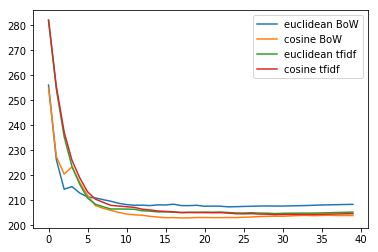

In [22]:
# Ваш код здесь

X_train1 = X_train['text'].to_numpy()
X_test1 = X_test['text'].to_numpy()
y_train1 = y_train.to_numpy()[:,0]
y_test1 = y_test.to_numpy()[:,0]

vectorizer_train = vectorizer.fit_transform(X_train1)
vectorizer_test = vectorizer.transform(X_test1)

X_train_tfidf = tfidf_transformer.fit_transform(vectorizer_train)
X_test_tfidf = tfidf_transformer.transform(vectorizer_test)

k_max = 40
metrics_array = ['euclidean', 'cosine']
res_matrix_length = k_max * len(metrics_array) * 2
res = np.zeros(res_matrix_length).reshape(k_max, len(metrics_array) * 2)
process_bar_length = res_matrix_length
cur_bar_position = 0
update_progress(cur_bar_position / res_matrix_length)
for t in range(len(['count', 'tfidf'])):
    for m in range(len(metrics_array)):
        for k in range(0, k_max):
            knnr = KNeighborsRegressor(n_neighbors = k + 1, metric = metrics_array[m], weights = 'distance')
            if (t):
                knnr.fit(X_train_tfidf, y_train1)
                pred = knnr.predict(X_test_tfidf)
            else:
                knnr.fit(vectorizer_train, y_train1)
                pred = knnr.predict(vectorizer_test)
            res[k][(t * len(metrics_array)) + m] = np.sqrt(mean_squared_error(y_test1, pred))
            cur_bar_position = cur_bar_position + 1
            update_progress(cur_bar_position / res_matrix_length)

plt.plot(res)
plt.legend(['euclidean BoW', 'cosine BoW', 'euclidean tfidf', 'cosine tfidf'], loc='upper right')
plt.show() 

In [23]:
print("Минимальная ошибка RMSE: %.4f" % np.min(res))

Минимальная ошибка RMSE: 202.9486


<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования. Повлияло ли добавление количественного признака на метрику качества?

In [24]:
# обрабатываем исходные фичи
labelencoder = LabelEncoder()
vectorizer = CountVectorizer(stop_words = 'english')
tfidf_transformer = TfidfTransformer()

onehotencoder = OneHotEncoder()
scaler = MinMaxScaler()

data = pd.read_csv('AB_NYC_2019.csv')
data.head()

data['last_review'] = pd.to_datetime(data['last_review'].fillna(0)).astype(int)

numberCols = data.select_dtypes(include=[np.number]).columns.tolist()
numberCols.remove('id')
numberCols.remove('price')

categoricalCols = ['neighbourhood_group', 'neighbourhood', 'room_type']

data[numberCols] = data[numberCols].fillna(0)
data[categoricalCols] = data[categoricalCols].fillna('')

textCols = ['name']
data[textCols] = data[textCols].fillna('')

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['price']), data[['price']],
    test_size=0.3, 
    random_state=241
)

X_train['neighbourhood_group_encoded'] = labelencoder.fit_transform(X_train['neighbourhood_group'])
X_train['neighbourhood_encoded'] = labelencoder.fit_transform(X_train['neighbourhood'])
X_train['room_type_encoded'] = labelencoder.fit_transform(X_train['room_type'])

X_test['neighbourhood_group_encoded'] = labelencoder.fit_transform(X_test['neighbourhood_group'])
X_test['neighbourhood_encoded'] = labelencoder.fit_transform(X_test['neighbourhood'])
X_test['room_type_encoded'] = labelencoder.fit_transform(X_test['room_type'])

X_train['text'] = X_train[['name', 'host_name']].apply(lambda row: ' - '.join(str(colval) for colval in row), axis=1)
X_train['text'].str.lower()

X_test['text'] = X_test[['name', 'host_name']].apply(lambda row: ' - '.join(str(colval) for colval in row), axis=1)
X_test['text'].str.lower()

train_scaled_df = scaler.fit_transform(X_train[numberCols])
train_scaled_df = pd.DataFrame(train_scaled_df, columns=[numberCols])

test_scaled_df = scaler.fit_transform(X_test[numberCols])
test_scaled_df = pd.DataFrame(test_scaled_df, columns=[numberCols])

vectorizer_train = sp.sparse.hstack( \
    (tfidf_transformer.fit_transform(vectorizer.fit_transform(X_train['text'])), \
     train_scaled_df[numberCols], X_train[['neighbourhood_group_encoded', 'neighbourhood_encoded', 'room_type_encoded']].values, \
    ), format='csr' \
)

vectorizer_test = sp.sparse.hstack( \
    (tfidf_transformer.transform(vectorizer.transform(X_test['text'])), \
     test_scaled_df[numberCols], X_test[['neighbourhood_group_encoded', 'neighbourhood_encoded', 'room_type_encoded']].values, \
    ), format='csr' \
)

vectorizer_train_onehot = sp.sparse.hstack( \
    (tfidf_transformer.fit_transform(vectorizer.fit_transform(X_train['text'])), \
     train_scaled_df[numberCols].values, \
     onehotencoder.fit_transform(X_train['neighbourhood_group'].values.reshape(-1, 1)), \
    ), format='csr' \
)

vectorizer_test_onehot = sp.sparse.hstack( \
    (tfidf_transformer.transform(vectorizer.transform(X_test['text'])), \
     test_scaled_df[numberCols].values, \
     onehotencoder.fit_transform(X_test['neighbourhood_group'].values.reshape(-1, 1)), \
    ), format='csr' \
)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
# подбираем параметры
grid_params = {
    'n_neighbors': [27, 29, 31, 33, 35],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

gs = GridSearchCV(
    KNeighborsRegressor(),
    grid_params,
    verbose = 11,
    cv = 3,
    n_jobs = 1
)

gs_results = gs.fit(vectorizer_train, y_train)
print(gs_results.best_params_)

gs_results = gs.fit(vectorizer_train_onehot, y_train)
print(gs_results.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] metric=euclidean, n_neighbors=27, weights=uniform ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=euclidean, n_neighbors=27, weights=uniform, score=0.14060307610804468, total=  13.6s
[CV] metric=euclidean, n_neighbors=27, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.8s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=uniform, score=0.09106591622822968, total=  13.1s
[CV] metric=euclidean, n_neighbors=27, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=uniform, score=0.09972084638119438, total=  13.5s
[CV] metric=euclidean, n_neighbors=27, weights=distance ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=distance, score=0.14891566176169302, total=  14.0s
[CV] metric=euclidean, n_neighbors=27, weights=distance ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=distance, score=0.0947557272470737, total=  13.5s
[CV] metric=euclidean, n_neighbors=27, weights=distance ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=distance, score=0.10394598344702477, total=  13.5s
[CV] metric=euclidean, n_neighbors=29, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.1min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=uniform, score=0.13834990952601534, total=  13.5s
[CV] metric=euclidean, n_neighbors=29, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.7min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=uniform, score=0.08949074422134473, total=  13.1s
[CV] metric=euclidean, n_neighbors=29, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.4min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=uniform, score=0.09867963571846648, total=  13.7s
[CV] metric=euclidean, n_neighbors=29, weights=distance ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.1min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=distance, score=0.1470553204885029, total=  13.5s
[CV] metric=euclidean, n_neighbors=29, weights=distance ..............


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.8min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=distance, score=0.09347409753716351, total=  13.5s
[CV] metric=euclidean, n_neighbors=29, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=29, weights=distance, score=0.10321038158254782, total=  13.6s
[CV] metric=euclidean, n_neighbors=31, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=31, weights=uniform, score=0.1401601335384941, total=  13.5s
[CV] metric=euclidean, n_neighbors=31, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=31, weights=uniform, score=0.08881635148474243, total=  13.9s
[CV] metric=euclidean, n_neighbors=31, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=31, weights=uniform, score=0.09937223169142949, total=  13.4s
[CV] metric=euclidean, n_neighbors=31, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=31, weights=distance, score=0.14873551627551607, total=  13.4s
[CV] metric=euclidean, n_neighbors=31, weights=distance

[CV]  metric=cosine, n_neighbors=35, weights=distance, score=0.08969242863925198, total=  14.3s
{'metric': 'euclidean', 'n_neighbors': 27, 'weights': 'distance'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] metric=euclidean, n_neighbors=27, weights=uniform ...............


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 41.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=euclidean, n_neighbors=27, weights=uniform, score=0.13367427705094226, total=  14.7s
[CV] metric=euclidean, n_neighbors=27, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.3s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=uniform, score=0.07815497208766542, total=  14.4s
[CV] metric=euclidean, n_neighbors=27, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=uniform, score=0.0785749100123837, total=  14.5s
[CV] metric=euclidean, n_neighbors=27, weights=distance ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=distance, score=0.14201681109755615, total=  14.8s
[CV] metric=euclidean, n_neighbors=27, weights=distance ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.9min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=distance, score=0.08113866499858147, total=  14.4s
[CV] metric=euclidean, n_neighbors=27, weights=distance ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=27, weights=distance, score=0.08282126397518774, total=  14.4s
[CV] metric=euclidean, n_neighbors=29, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.4min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=uniform, score=0.135512164646452, total=  13.6s
[CV] metric=euclidean, n_neighbors=29, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.0min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=uniform, score=0.07817440202029469, total=  13.4s
[CV] metric=euclidean, n_neighbors=29, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.7min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=uniform, score=0.08117823794609946, total=  13.5s
[CV] metric=euclidean, n_neighbors=29, weights=distance ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.4min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=distance, score=0.14362008214142463, total=  13.7s
[CV] metric=euclidean, n_neighbors=29, weights=distance ..............


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.1min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=29, weights=distance, score=0.08123708398282103, total=  13.4s
[CV] metric=euclidean, n_neighbors=29, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=29, weights=distance, score=0.08526779099368942, total=  13.4s
[CV] metric=euclidean, n_neighbors=31, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=31, weights=uniform, score=0.13478083630764304, total=  13.7s
[CV] metric=euclidean, n_neighbors=31, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=31, weights=uniform, score=0.07775460690860181, total=  13.4s
[CV] metric=euclidean, n_neighbors=31, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=31, weights=uniform, score=0.08082116480074208, total=  13.4s
[CV] metric=euclidean, n_neighbors=31, weights=distance ..............
[CV]  metric=euclidean, n_neighbors=31, weights=distance, score=0.14281325743917395, total=  13.7s
[CV] metric=euclidean, n_neighbors=31, weights=distanc

[CV]  metric=cosine, n_neighbors=35, weights=distance, score=0.08297355022233455, total=  13.1s
{'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 40.4min finished


In [26]:
knnr = KNeighborsRegressor(n_neighbors = 29, metric = 'euclidean', weights = 'distance')
knnr.fit(vectorizer_train_onehot, y_train)
pred = knnr.predict(vectorizer_test_onehot)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("The best RMSE value is %.4f" % rmse)

The best RMSE value is 203.4117


Progress: [####################] 100.0%


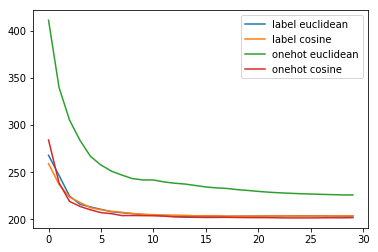

In [27]:
# Ваш код здесь
# Просто посмотрим как изменяется качество от k

k_max = 30
cur_bar_position = 0
res_matrix_length = k_max * len(metrics_array) * 2
metrics_array = ['euclidean', 'cosine']
res = np.zeros(res_matrix_length).reshape(k_max, len(metrics_array) * 2)
process_bar_length = res_matrix_length
cur_bar_position = 0
update_progress(cur_bar_position / res_matrix_length)
for t in range(len(['label', 'onehot'])):
    for m in range(len(metrics_array)):
        for k in range(0, k_max):
            knnr = KNeighborsRegressor(n_neighbors = k + 1, metric = metrics_array[m], weights = 'distance')

            if (t):
                knnr.fit(vectorizer_train, y_train)
                pred = knnr.predict(vectorizer_test)
            else:
                knnr.fit(vectorizer_train_onehot, y_train)
                pred = knnr.predict(vectorizer_test_onehot)
            
            res[k][(t * len(metrics_array)) + m] = np.sqrt(mean_squared_error(y_test, pred))
            cur_bar_position = cur_bar_position + 1
            update_progress(cur_bar_position / res_matrix_length)

plt.plot(res)
plt.legend(['label euclidean', 'label cosine', 'onehot euclidean', 'onehot cosine'], loc='upper right')
plt.show() 

In [28]:
print("Минимальная ошибка RMSE: %.4f" % np.min(res))

Минимальная ошибка RMSE: 201.4969


## Часть 4: Выводы


# Ваши выводы здесь (ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆

Я "вольный слушатель" курса и моей целью является изучение ML. 

Когда я начал решать задание, я понял, что вообще не понимаю что и зачем я делаю. Потом я посмотрел как это работает в sklearn и многое проянилось. И так от задания к заданию, пока я наконец-таки не пришел к выводу, что мне нужно решить задачу на sklearn, и толкьо после этого углубляться в отдельный функционал.

Собственно, так и сделал. Что изучил:

1. Исследовал и реализовал Эвклидову и Косинусную метрики. overlap, overlap_flattened, overlap_log не осилил (выдают не верные данные) и не понял где это в sklearn. 

2. Изучил кодирование категориальных признаков через LabelEncoder и OneHotEncoder. Ошибка на втором оказазалась ниже.

3. Изучил алгоритмы кодирования текста "Мешок слов" и tfidf. Получил самый лучший результат на OneHot с косинусной метрикой.

4. Собрал все в единый набор фич и получил на моделе RMSE = 201.5

Хотелось бы узнать, правильно ли я решил задачу регрессии и какие ошибки были допущены в процессе подготовки данны. Как можно еще уменьшить RMSE?